# 第3章 分類
前章では線形回帰，決定木，ランダムフォレストなどのアルゴリズムを用いて住宅価格の予測を行った．  
ここでは，分類システムについて見ていく．

## 3.1 MNIST
MNISTは70,000枚の手書き数字画像のデータセットであり，機械学習を学ぶ上で非常によく用いられる．  
Scikit-LearnにはMNISTをダウンロードするためのヘルパー関数があり，次のようにデータセットをフェッチできる．  

In [75]:
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [4]:
mnist = fetch_openml('mnist_784', version=1)
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',


scikit-learn のヘルパー関数では一般にほぼ同じような辞書構造でデータセットがロードされる．
- DESCRキー：データセットの説明
- dataキー：各行がインスタンス，各列が特徴量を表す
- targetキー：ラベルの配列

70,000枚の画像データは$28\times28$ピクセルの画像をベクトルに変換した状態で格納されており，各ベクトルの特徴量は0から255までの値を取る．

X shape :  (70000, 784) , y shape :  (70000,)
Image Index:  51164 , label:  8


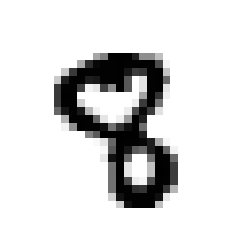

In [11]:
X, y = mnist["data"], mnist["target"]
print("X shape : ", X.shape, ", y shape : ", y.shape)

idx = random.randint(0, len(X))
print("Image Index: ", idx, ", label: ", y[idx])
some_digit = X[idx]
some_digit_img = some_digit.reshape(28, 28)

plt.imshow(some_digit_img, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

ここで，訓練セット6万枚とテストセット1万枚にデータセットを分割し，さらに訓練セットをシャッフルしておく．

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_idx = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

## 3.2 二項分類器の訓練
最初に数字をひとつだけ識別できるようにしてみる．
ここでは，5と5以外の2つのクラスだけを識別できる**二項分類器**(binary classifier)を例に訓練を行う．

In [17]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

scikit-learn の SGDClassifierクラスを用いて**確率的勾配降下法**(Stocastic Gradient Descent : SGD)の分類器によって試してみる．この分類器は各インスタンスをそれぞれ1つずつ独立に扱うことから，非常に大規模なデータセットを効率良く扱うことができる．

In [19]:
# モデルの学習
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# 学習された分類器で 5 の画像を識別させてみる
pred = sgd_clf.predict([X[0]])
print(pred)

[ True]


## 3.3 性能指標
### 3.3.1 交差検証を使った正解率の測定
cross_val_score()関数を使って$K=3$のK分割交差検証で先程のモデルを評価してみる．

In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95925, 0.96255, 0.96995])

見かけ上，素晴らしい正解率（accuracy）だが，試しに全ての画像を「5以外」として識別する分類器の結果を見てみる．

In [23]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9136 , 0.90325, 0.9121 ])

画像の約10%が5で90%は5以外なので，常に「5以外」と予測していれば約90%の確率で当てられる．  
そのため，分類器の性能指標として正解率は一般に好ましくない．
特に，一部のクラスの出現頻度が他のクラスよりも高い**歪んだデータセット**(skewed dataset)では，正解率は当てにならない． 

### 3.3.2 混同行列
分類器の性能評価方法としては**混同行列**(confusion matrix)のほうが優れている．
これは，クラスAのインスタンスがクラスBに誤分類された回数を数えた行列である．
例えば，分類器が5の画像を3と誤分類した回数は第5行第3列を見ればよい．  
混同行列を計算するには，まず cross_val_predict() 関数でK分割交差検証を行った際の予測結果を得る．
これを confusion_matrix() 関数に渡して混同行列を計算する．

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53686,   893],
       [ 1272,  4149]])

混同行列の各行は実際のクラス，各列は予測したクラスを表す．
行列の第 1 行は 5 以外の画像(**陰性クラス**: negative class)であり，そのうち 53,272 件は正しく 5 以外と分類され(**真陰性**: true negative )，1,307 件は誤って 5 と分類されている(**偽陽性**: false positive)．
それに対し，行列の第 2 行は 5 の画像(**陽性クラス**: positive class)であり，そのうち 1,077 件は誤って 5 以外と分類され(**偽陰性**: false negative)，4,344 件は正しく 5 と分類されている(**真陽性**: truepositive)．  
完全な分類器では真陽性と真偽性だけで，主対角線が0となる．

混同行列よりも簡潔な指標として陽性と予測した場合の正解率である**適合率**(precision) がある．
TP は真陽性数，FPは偽陽性数を表す．

$$
precision = \frac{TP}{TP+FP}
$$

適合率100%を実現するには，1個だけ陽性の予測を行い，これを必ず正しいものにすれば良い．
しかし，これでは1個の陽性インスタンス以外のインスタンスを全て無視してしまうことになり，意味をなさない．
そこで，**再現率**(recall) という指標と合わせて用いられる．
この指標は，**感度**(sensitivity)や**真陽性率**(true positive rate: TPR) とも呼ばれ，分類器が正しく分類した陽性インスタンスの割合を表す．
TP は真陽性数，FPは偽陰性数をである．

$$
recall = \frac{TP}{TP+FN}
$$

### 3.3.3 適合率と再現率
scikit-learn では適合率や再現率を含む複数の性能指標を計算できる関数が複数提供されている．

In [27]:
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print("Precision : ", precision, ", Recall : ", recall)

Precision :  0.8228877429591432 , Recall :  0.7653569452130603


先程訓練した分類器が5と予測したもののうち，本当に5なのは約82%だけで，全ての5の画像のうち検出できたのは約77%だけである．

適合率と再現率を1つにまとめた指標が**F値**である．
F値は適合率と再現率の**調和平均**(harmonic mean)である．

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}}
$$

In [29]:
f1_score(y_train_5, y_train_pred)

0.7930803784765363

F値は適合率と再現率が同じように高い分類器を高く評価するが、いつもそれが望ましいわけではない．
適合率の方が重視される場合や再現率の方が重視される場合がある．
たとえば，子どもに見せても安心なビデオを検出する分類器を訓練している場合，多くのよいビデオを排除しても安全なビデオだけを選ぶ分類器の方が，再現率が高くても少数の非常に危険なビデオが入り込む分類器よりもよいと考えられる．
それに対し、監視ビデオから万引き犯を見つける分類器を訓練している場合には，再現率が99%であれば，適合率が30%しかなくても，その分類器は使えるはずである．

### 3.3.4 適合率と再現率のトレードオフ
適合率が上がれば再現率が下がり，逆もまた成り立つ．
すなわち，適合率と再現率はトレードオフの関係にある．  
SGDClassifierは個々のインスタンスに対して，**決定関数**(decision function)に基づいてスコアを計算し，そのスコアがしきい値よりも高ければ，インスタンスは陽性クラスに，そうでなければ陰性クラスに分類される．
下図は最低スコア(左端)から最高スコア(右端)までのさまざまな数字を示している．

<img src="img/ch03/p90_1.png" width="75%">

**決定しきい値**(decision threshold)を中央の矢印(ふたつの5の間)に置くと，しきい値の右側には4個の真陽性(実際に5)と1個の偽陽性(実際には6)が含まれることになる．
そのため，ここをしきい値とすると，適合率は80%になる(5個のうちの4個)．
しかし，6個ある5のうち，分類器が検出しているのは4個だけなので，再現率は67%(4/6)になる．
しきい値を上げると(右側の矢印)，偽陽性だった6が新陰性になって適合率は上がる(この場合は100%)が，1個の真陽性が偽陰性になってしまうため再現率は50%に下がる．
逆にしきい値を下げれば再現率は上がるが適合率が下がる．

scikit-learnは，しきい値を直接設定できるようにはなっていないが，予測のときに使う決定スコアにはアクセスできるようになっている．
分類器のpredict()メソッドを呼び出す代わりにdecision_function()メソッドを呼び出すと，各インスタンスのスコアが返される．
そこで，使いたいしきい値とスコアを比較して予測を決めていけばよい．

In [32]:
y_scores = sgd_clf.decision_function([X[0]])
print("y_scores : ", y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("y_some_digit_pred (threshold=0):", y_some_digit_pred)

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print("y_some_digit_pred (threshold=200000):", y_some_digit_pred)

y_scores :  [2899.97146917]
y_some_digit_pred (threshold=0): [ True]
y_some_digit_pred (threshold=200000): [False]


しきい値を決定するには，まず，cross_val_predict()関数を使って訓練セットのすべてのインスタンスのスコアを計算し，決定スコアを返させる．
次に，あらゆるしきい値について適合率と再現率を計算し，しきい値の関数としてそれぞれをプロットする．
または，適合率と再現率を直接対比させても良い．
最後に，タスクの性質に合わせて適合率と再現率のバランスが良くなるようなしきい値を選んでやる．

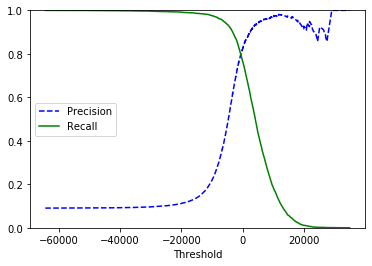

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

例えば，90%の適合率を目指すしてしきい値を2,500に設定してみると，再現率は約60%となる．

In [43]:
y_train_pred_90 = (y_scores > 2500)
precision = precision_score(y_train_5, y_train_pred_90)
recall = recall_score(y_train_5, y_train_pred_90)
print("Precision: ", precision, ", Recall: ", recall)

Precision:  0.901305057096248 , Recall:  0.6115107913669064


### 3.3.5 ROC曲線
二項分類器では，**ROC曲線**(Receiver Operating Characteristic: 受信者動作特性曲線)もよく用いられる．
これは，**偽陽性率**(false positive ratio: FPR)に対する**真陽性率**(true positive ratio: TPR)をプロットしたものである．
FPR は誤って陽性と分類された陰性インスタンスの割合である．
これは，1から**真陰性率**(true negative ratio: TNR )を引いた値と等しい．
TNR は正しく陰性に分類された陰性インスタンスの割合で，**特異度**(specificity)とも呼ばれる．
そのため，ROC曲線は（1−特異度）に対する**感度**(sensitivity: 再現率)をプロットした曲線だと言うことができる．

ROC 曲線を描くためには，roc_curve()関数を使ってさまざまなしきい値でのTPRとFPRを計算する必要がある．

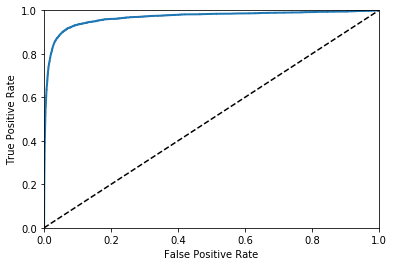

In [47]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

TPRが上がれば上がるほどFPRも上がるというトレードオフがある．
点線は純粋に無作為な分類器の ROC 曲線を表している．
すぐれた分類器は，ROC曲線がこの線からできる限り左上の方に離れた位置を通る．  
分類器の比較には，**AUC**(area under the curve: 曲線の下の面積)が使える．
完璧な分類器は**ROC AUC**が1になるのに対し，純粋無作為分類器のROC AUCは0.5になる．

In [49]:
roc_auc_score(y_train_5, y_scores)

0.9669774127465381

ここから，RandomForestClassifierを訓練し，SGDClassifierと比較してみる．
RandomForestClassifier には decision_function() メソッドの代わりに，各インスタンスが各クラスに属する確率を返す predict_proba() メソッドがある．

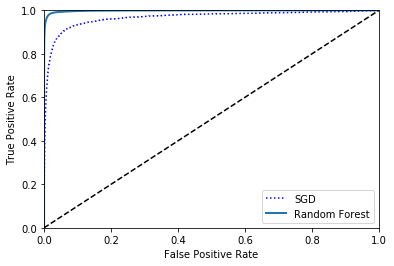

In [52]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]  # 陽性クラスの確率
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [53]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983690911538091

## 3.4 多クラス分類
**多クラス分類器**(multiclassclassifier，多項分類器: multinomial classifierとも呼ばれる)は，ふたつ以上のクラスを見分けることができる．  
ランダムフォレスト分類器や単純ベイズ分類器などは多クラスを直接処理できるが，サポートベクトルマシンや線形分類器などは厳密に二項分類器である．
しかし，複数の二項分類器を使って多クラス分類を行うための方法はいくつかある．

- **OVA法**(one-versus-all，**OVR法**: oner-versus-rest)  
あるクラスとそれ以外を識別する分類器をクラス数分だけ用意し，分類器の決定スコアが最も高いクラスを選択．
- **OVO法**(one-versus-one)  
すべてのクラスのペアに対して二項分類器を訓練し，もっとも多く出力されたクラスを選択．

OVO法(one-versus-one)では，N個のクラスがある場合，N×(N − 1)/2 個の分類器を訓練しなければならない．
OVO 法の最大の利点は訓練セットのうち、区別しなければならないふたつのクラスに属するインスタンスだけを対象として分類器を訓練できることである．  
サポートベクトルマシンなどは，訓練セットのサイズが大きくなると遅くなるため，OVO法を使って大規模な訓練セットで少数の分類器を訓練するよりも，小さな訓練セットで多数の分類器を訓練する方が早い．
しかし，大半の二項分類アルゴリズムではOVAの方がよい．
scikit-learnでは，他クラス分類のために二項分類アルゴリズムを使おうとすると，それを検出して自動的にOVA法を実行する(ただし，SVM分類器ではOVO法が使われる)．
SGDClassifierでこれを試してみる．

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]])

array(['5'], dtype='<U1')

上記のコードを実行すると，実際に10個の二項分類器を学習し，画像に対するそれぞれの決定スコアが計算される．

In [56]:
sgd_clf.decision_function([X[0]])

array([[-12931.04480533, -36186.74773799,  -8494.44143112,
         -1315.64226172, -26035.54283057,   1330.11751017,
        -34115.84486468, -22778.62233224,  -7063.79757596,
        -13160.88920864]])

In [57]:
sgd_clf.classes_[np.argmax(sgd_clf.decision_function([X[0]]))]

'5'

OneVSOneClassifier クラスや OneVSRestClassifier クラスを使えば，OVO や OVAの使用を指定できる．

In [59]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X[0]])

array(['3'], dtype=object)

In [60]:
len(ovo_clf.estimators_)

45

RandomForestClassifier も同様に訓練できる．
ランダムフォレストは直接多クラス分類に対応できるため，OVA や OVO を指定する必要はない．
predict_proba() メソッドを呼び出せば，各クラスに分類する確率のリストが得られる．
この例では，画像が5である確率が88%と予測されている．

In [61]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X[0]])

array(['5'], dtype=object)

In [62]:
forest_clf.predict_proba([X[0]])

array([[0.  , 0.01, 0.  , 0.1 , 0.  , 0.88, 0.  , 0.  , 0.01, 0.  ]])

SGDClassifier の適合率を交差検証してみる．

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87605, 0.87875, 0.88755])

全てのテストフォールドで87%を超えており悪くないようだが，単にスケーリングを施すだけでも適合率は上昇する．

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,scoring="accuracy")

array([0.89515, 0.8987 , 0.89975])

## 3.5 誤分類の分析
すでに有望なモデルが見つかっている場合，その改良方法を探すにはモデルの犯す誤分類のタイプを分析する必要がある．  
はじめに混同行列を確認する．

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5575,    0,   18,    8,    9,   37,   32,    3,  240,    1],
       [   1, 6421,   43,   19,    3,   40,    4,    7,  195,    9],
       [  25,   24, 5271,   74,   66,   22,   64,   39,  366,    7],
       [  26,   20,  124, 5221,    1,  187,   24,   48,  418,   62],
       [  13,   13,   46,    9, 5204,    8,   31,   21,  350,  147],
       [  25,   21,   30,  155,   53, 4424,   77,   13,  562,   61],
       [  26,   16,   46,    2,   42,   81, 5550,    5,  150,    0],
       [  22,   12,   52,   24,   43,   10,    5, 5694,  206,  197],
       [  16,   62,   45,   93,    3,  117,   30,    6, 5444,   35],
       [  25,   23,   30,   58,  122,   33,    1,  178,  411, 5068]])

Matplotlib の matshow() 関数で混同行列を可視化できる．

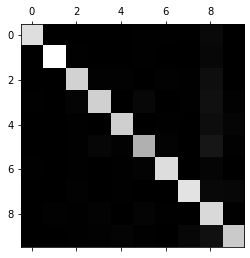

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

ほとんどが主対角線に集まっており，正しく分類されているのでかなりよいように見える．
5はほかの数字よりも少し暗い色になっているが，これはデータセットに含まれる5の画像が少なかったか，分類器がほかの数字と比べて5では性能が低かったことを意味している．  
プロットの誤りの部分に注目する．
混同行列の個々の数値を対応するクラスの画像数で割り，誤分類の絶対数ではなく誤り率を比較できるようにして，対角成分に0をセットして誤分類だけを残して結果をプロットしてみる．

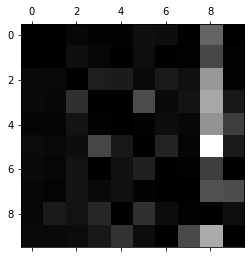

In [69]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

上の図を見てみると8と9の列が他の列に比べて明るくなっており，8と9が間違われやすいことがわかる．
逆に，1はほとんどが正しく分類されている．
また，誤分類は完全に対象的にはなっていない．  
この混同行列の観察から，3と5，8と9の誤分類の修正に注力すれば良さそうだとわかる．
そのためには，これらの数字の画像データをもっと集めてきたり，新しい特徴量を設計したりといった方策が考えられる．  
個別の誤差を分析することで，分類器が何を行い，何故ご分類してしまうのか洞察を得るために役立つ．
例えば，3と5をプロットしてみる．
左側が3と分類された数字，右側が5と分類された数字であり，右上と左下が誤分類された数字である．

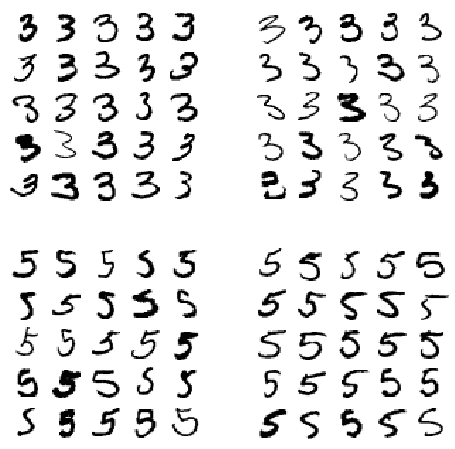

In [74]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

人の目には明らかに誤りとわかる誤分類がほとんどであるが，これは分類に単純に線形モデルを使用しているためである．
3と5は明度の異なるピクセル数が少ないために，単純な線形モデルでは分類できない．  
3 と 5 でもっとも大きく違うのは，上の線と下の円弧をつなぐ短い線の位置である．
この線の位置を少し左寄りにして3を描くと，分類器はそれを5に分類し，その逆も起こる．
つまり，この分類器は画像の平行移動と回転に敏感に反応する．
そこで，画像があまり回転されていない形で中央に現れるように前処理すれば良いのではないかと考えられる．

## 3.6 多ラベル分類
複数の2値ラベルを出力するような分類モデルを**多ラベル分類**(multilabel classification)と呼ぶ．  
下の例では，数字が (7, 8, 9) のいずれかであるかを表すラベルと，数字が奇数であるかを表すラベルの2ラベルの多ラベル分類を行っている．

In [77]:
y_train_large = [(int(y) >= 7) for y in y_train]
y_train_odd = [(int(y) % 2 == 1) for y in y_train]
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [79]:
knn_clf.predict([X[0]])

array([[False,  True]])

多ラベル分類器の評価方法は多数あり，プロジェクト次第で指標の選び方は異なるが，その1つとして個々のラベルのF値を計測し，単純に平均を取った指標がある．

In [80]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9770881746310258

上記は，すべてのラベルの重要度が等しいことを前提としているが，そうではない場合には，単純な方法として**サポート**(support，すなわちターゲットラベルを持つインスタンスの数)に応じた重みを各ラベルに与えることができる．
上記のコードで，average="weighted" を指定すればよい．

## 3.7 多出力分類
**多出力多クラス分類**(multioutput-multiclass classification，あるいは単純に**多クラス分類**: multioutput classification)は，単純に個々のラベルが多クラスでもよい(複数の値を持ってよい)という形に多ラベル分類を一般化したものである．  
例として画像からノイズを取り除くシステムを作ってみる．
ノイズの入った数字の画像を与えると，MNIST 画像のようにピクセルの明度の配列という形で表現されたクリーンな数字の画像を出力する．
分類器の出力が多ラベル(ピクセルごとに1ラベル)で，個々のラベルが複数の値(ピクセルの明度は0から255までの範囲)である．  
最初に NumPy の randint() 関数で MNIST 画像のピクセルにノイズを加えて訓練セットとテストセットを作る．

In [81]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

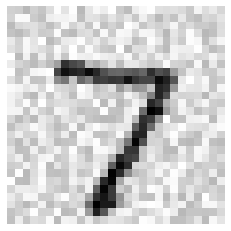

In [82]:
X_test_mod_img = X_test_mod[0].reshape(28, 28)
plt.imshow(X_test_mod_img, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

分類器を学習し，このノイズの入った画像を入力してノイズを除去してみる．

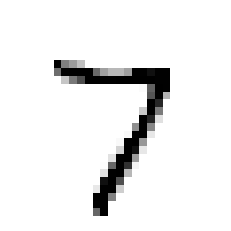

In [83]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

うまくノイズ除去できている．

## 3.8 演習問題